In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots
import ForwardDiff as FD
using Printf
using JLD2

  Activating environment at `C:\Users\rdesa\OneDrive\Desktop\OCRL_HW1\HW1_S23-main\Project.toml`


## Q2 (20 pts): Augmented Lagrangian Quadratic Program Solver

Here we are going to use the augmented lagrangian method described [here in a video](https://www.youtube.com/watch?v=0x0JD5uO_ZQ), with [the corresponding pdf here](https://github.com/Optimal-Control-16-745/lecture-notebooks-2022/blob/main/misc/AL_tutorial.pdf) to solve the following problem:

$$\begin{align}
\min_x \quad & \frac{1}{2}x^TQx + q^Tx \\ 
\mbox{s.t.}\quad &  Ax -b = 0 \\ 
&  Gx - h \leq 0 
\end{align}$$
where the cost function is described by $Q \in \mathbb{R}^{n \times n}$, $q \in \mathbb{R}^n$, an equality constraint is described by $A \in \mathbb{R}^{m \times n}$ and $b \in \mathbb{R}^m$, and an inequality constraint is described by $G \in \mathbb{R}^{p \times n}$ and $h \in \mathbb{R}^p$.


By introducing a dual variable $\lambda \in \mathbb{R}^m$ for the equality constraint, and $\mu \in \mathbb{R}^p$ for the inequality constraint, we have the following KKT conditions for optimality:

$$\begin{align}
Qx + q + A^T\lambda + G^T \mu &= 0 \quad \quad \text{stationarity}\\ 
Ax-b&= 0 \quad \quad \text{primal feasibility} \\ 
Gx-h&\leq 0 \quad \quad \text{primal feasibility} \\ 
\mu &\geq 0 \quad \quad \text{dual feasibility} \\ 
\mu \circ (Gx - h) &= 0 \quad \quad \text{complementarity}
  \end{align}$$
  where $\circ$ is element-wise multiplication.  

In [2]:
function cost(qp::NamedTuple, x::Vector)::Real
    0.5*x'*qp.Q*x + dot(qp.q,x)
end

cost (generic function with 1 method)

In [3]:
function c_eq(qp::NamedTuple, x::Vector)::Vector
    qp.A*x - qp.b 
end

c_eq (generic function with 1 method)

In [4]:
function h_ineq(qp::NamedTuple, x::Vector)::Vector
    qp.G*x - qp.h
end

h_ineq (generic function with 1 method)

In [5]:
function mask_matrix(qp::NamedTuple, x::Vector, μ::Vector, ρ::Real)::Matrix
    IP = zeros(length(h_ineq(qp,x)),length(h_ineq(qp,x)))
    for i = 1:(length(h_ineq(qp,x)))
        if μ[i] <= 0 && h_ineq(qp,x)[i] < 0  
            IP[i,i] = 0;
        else
            IP[i,i] = ρ;
        end
    end
    return IP
    error("not implemented")
end

mask_matrix (generic function with 1 method)

In [6]:
function augmented_lagrangian(qp::NamedTuple, x::Vector, λ::Vector, μ::Vector, ρ::Real)::Real
    Lag = cost(qp,x) + (λ'*c_eq(qp,x)) + (μ'*h_ineq(qp,x)) + (0.5*ρ*c_eq(qp,x)'*c_eq(qp,x))+(0.5*h_ineq(qp,x)'*mask_matrix(qp,x,μ,ρ)*h_ineq(qp,x))
    return Lag
    #what to do with penality term
    error("not implemented")
end

augmented_lagrangian (generic function with 1 method)

In [7]:
function logging(qp::NamedTuple, main_iter::Int, AL_gradient::Vector, x::Vector, λ::Vector, μ::Vector, ρ::Real)
    # TODO: stationarity norm
    stationarity_norm = norm(FD.gradient(dx -> cost(qp,dx),x) + FD.jacobian(dx -> c_eq(qp,dx),x)'*λ + FD.jacobian(dx -> h_ineq(qp,dx), x)'*μ) 
    # fill this in 
    @printf("%3d  % 7.2e  % 7.2e  % 7.2e  % 7.2e  % 7.2e  %5.0e\n",
          main_iter, stationarity_norm, norm(AL_gradient), maximum(h_ineq(qp,x)),
          norm(c_eq(qp,x),Inf), abs(dot(μ,h_ineq(qp,x))), ρ)
end

logging (generic function with 1 method)

In [8]:
function Newton(qp, x, λ, μ, ρ, Beta, max_iters)     
        for max_iters = 1:100
            Lp = augmented_lagrangian(qp, x, λ, μ, ρ)
            DLp = FD.gradient(dx -> augmented_lagrangian(qp, dx, λ, μ, ρ),x)
            D2Lp = FD.hessian(dx -> augmented_lagrangian(qp, dx, λ, μ, ρ),x)
            #Regularization
            D2Lp = D2Lp
            Δx = -D2Lp\DLp
            x = x + Δx
                
            if norm(FD.gradient(dx -> augmented_lagrangian(qp, dx, λ, μ, ρ),x)) < 1e-5
                return x
        end
    end
    print("Not converging")
    return x
end

Newton (generic function with 1 method)

In [9]:
function kkt(qp, x, λ, μ, ρ)
    tol=1e-3
    DLp = FD.gradient(dx -> augmented_lagrangian(qp, dx, λ, μ, ρ),x)
    Axb = c_eq(qp,x)
    Gxb = h_ineq(qp,x)
    #print("\n Axb \n")
    #print(norm(c_eq(qp,x),Inf))
    #print(norm(c_eq(qp,x),Inf))
    #print("\n Gxb \n")
    #print(max(0,maximum(h_ineq(qp,x))))
    #maximum of Gxb is less than tol 
    if (norm(c_eq(qp,x),Inf) < tol && max(0,maximum(h_ineq(qp,x))) <= tol)
        return true
    else 
        return false
    end
end

kkt (generic function with 1 method)

In [10]:
VV = [1 2 -3 -4]
MM = maximum(VV)
print(MM)

2

In [11]:
function solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-8)
    x = zeros(length(qp.q))
    λ = zeros(length(qp.b))
    μ = zeros(length(qp.h))
    ρ = 1
    phi = 10
    Beta = 1
            
    if verbose
        @printf "iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ\n"
        @printf "----------------------------------------------------------------\n"
    end
    
    # TODO:
    for main_iter = 1:max_iters
        
        DALx = FD.gradient(dx -> augmented_lagrangian(qp, dx, λ, μ, ρ), x)
        
        if verbose
            logging(qp, main_iter, DALx, x, λ, μ, ρ)#0.0)
        end
        
        #Create Newton to find minimum here
        
        x = Newton(qp, x, λ, μ, ρ, Beta, max_iters)
                            
        λ = λ + (ρ*c_eq(qp, x)) 
        
        #check julia notation here
        μ .= max.(0,μ+ρ*h_ineq(qp, x))
        #check for 0 max.(0,mu+hineq) #because if negative then 0 otherwise mu max positive
        
        ρ = ρ*phi
        
        # TODO: convergence criteria based on tol 
        #check structure here
        
        if kkt(qp, x, λ, μ, ρ)
            return x, λ, μ
        end
                
    end
    return x, λ, μ
    error("qp solver did not converge")
end

solve_qp (generic function with 1 method)

In [12]:
VV = [1 2 -3 -4]
VV .= max.(0,VV)
print(VV)

[1 2 0 0]

In [13]:
let 
    # example solving qp 
    @load joinpath(@__DIR__, "qp_data.jld2") qp 
    x, λ, μ = solve_qp(qp; verbose = true, tol = 1e-8)
end

iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   2.98e+01   5.60e+01   4.38e+00   6.49e+00   0.00e+00  1e+00
  2   1.10e-14   4.92e+01   5.51e-01   1.27e+00   4.59e-01  1e+01
  3   6.16e+00   8.87e+01   2.56e-02   3.07e-01   1.05e-02  1e+02
  4   5.52e-01   4.28e+01   6.84e-03   1.35e-02   7.94e-03  1e+03


([-0.326186674510191, 0.24949388703332617, -0.432190448272202, -1.4172193105804867, -1.3995210523031858, 0.6099928113130458, -0.07312449141800163, 1.3031434540367792, 0.5388900439235766, -0.7226347050345036], [-0.12823419500886468, -2.837717107754922, -0.8322858252247742], [0.03640903482260427, 0.0, 0.0, 1.0595504446975539, 0.0])

## QP Solver test (10 pts)

In [14]:
# 10 points 
using Test 
@testset "qp solver" begin 
    @load joinpath(@__DIR__, "qp_data.jld2") qp 
    x, λ, μ = solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-6)
    
    @load joinpath(@__DIR__, "qp_solutions.jld2") qp_solutions
    @test norm(x - qp_solutions.x,Inf)<1e-3;
    @test norm(λ - qp_solutions.λ,Inf)<1e-3;
    @test norm(μ - qp_solutions.μ,Inf)<1e-3;
end

iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   2.98e+01   5.60e+01   4.38e+00   6.49e+00   0.00e+00  1e+00
  2   1.10e-14   4.92e+01   5.51e-01   1.27e+00   4.59e-01  1e+01
  3   6.16e+00   8.87e+01   2.56e-02   3.07e-01   1.05e-02  1e+02
  4   5.52e-01   4.28e+01   6.84e-03   1.35e-02   7.94e-03  1e+03
Test Summary: | Pass  Total
qp solver     |    3      3


Test.DefaultTestSet("qp solver", Any[], 3, false, false)

# Simulating a Falling Brick with QPs
In this question we'll be simulating a brick falling and sliding on ice in 2D. You will show that this problem can be formulated as a QP, which you will solve using an Augmented Lagrangian method.

## The Dynamics
The dynamics of the brick can be written in continuous time as
$$ M \dot{v}  + M g = J^T \lambda \\ \text{ where } M = mI_{2\times 2}, \; g = \begin{bmatrix} 0 \\ 9.81 \end{bmatrix},\; J = \begin{bmatrix} 0 & 1 \end{bmatrix} $$
and $\lambda \in \mathbb{R}$ is the normal force. The velocity $v \in \mathbb{R}^2$ and position $q \in \mathbb{R}^2$ are composed of the horizontal and vertical components.

We can discretize the dynamics with backward Euler:
$$ \begin{bmatrix} v_{k+1} \\ q_{k+1} \end{bmatrix} = \begin{bmatrix} v_k \\ q_k \end{bmatrix}
+ \Delta t \cdot \begin{bmatrix} \frac{1}{m} J^T \lambda_{k+1} - g \\ v_{k+1} \end{bmatrix}$$

We also have the following contact constraints:
$$ \begin{align}
J q_{k+1} &\geq 0 &&\text{(don't fall through the ice)} \\
\lambda_{k+1} &\geq 0 &&\text{(normal forces only push, not pull)} \\
\lambda_{k+1} J q_{k+1} &= 0 &&\text{(no force at a distance)}
\end{align} $$

## Part (a): QP formulation (5 pts)
Show that these discrete-time dynamics are equivalent to the following QP by writing down the KKT conditions.

$$ \begin{align}
    &\text{minimize}_{v_{k+1}} && \frac{1}{2} v_{k+1}^T M v_{k+1} + [M (\Delta t \cdot g - v_k)]^Tv_{k+1} \\
    &\text{subject to} && -J(q_k + \Delta t \cdot v_{k+1}) \leq 0 \\
\end{align} $$

**TASK**: Write down the KKT conditions for the optimization problem above, and show that it's equivalent to the dynamics problem stated previously. Use LaTeX markdown.

**PUT ANSWER HERE:**

## Solution 
positon q is equal to the original position plus the velocity multiplied by the change in time giving 
$$ \begin{align}
    q_{k+1} = q_k + \Delta t \cdot v_{k+1}
\end{align} $$

By taking the derivative of the Lagrangian with respect to x we get v k+1

$$ \begin{align}
    & Lagrange = \frac{1}{2} v_{k+1}^T M v_{k+1} + [M (\Delta t \cdot g - v_k)]^Tv_{k+1} 
    -J \lambda (q_k + \Delta t \cdot v_{k+1}) \\
    & DxLagrange = \ M v_{k+1} + [M (\Delta t \cdot g - v_k)] -J \lambda (q_k + \Delta t) \\
    & 0 = M v_{k+1} + [M (\Delta t \cdot g - v_k)] -J \lambda (q_k + \Delta t)\\
    & -M v_{k+1} = [M (\Delta t \cdot g - v_k)] -J \lambda (q_k + \Delta t)\\
    & v_{k+1} = v_k + \Delta t [\frac{1}{m} J^T\lambda -g]\\
\end{align} $$


By taking the intial contraint and substituting q+1 we get 

$$ \begin{align}
    &-J(q_k + \Delta t \cdot v_{k+1}) \leq 0 \\
    & J(q_k + \Delta t \cdot v_{k+1}) \geq 0\\
\end{align} $$

Sub in 
$$ \begin{align}
q_{k+1} = q_k + \Delta t \cdot v_{k+1}
\end{align} $$

$$ \begin{align}
    & Jq_{k+1} \geq 0 \\
\end{align} $$


## Brick Simulation (5 pts)

In [15]:
function brick_simulation_qp(q, v; mass = 1.0, Δt = 0.01)
    
    # TODO: fill in the QP problem data for a simulation step 
    # fill in Q, q, G, h, but leave A, b the same 
    # this is because there are no equality constraints in this qp 
    M = mass*[1 0; 0 1]
    g = [0 ; 9.81]
    J = [0 1]
    qp = (
        Q = M,
        q = M*(((Δt*g)-v)),
        A = zeros(0,2), # don't edit this
        b = zeros(0),   # don't edit this 
        G = -J*Δt,
        h = J*q,
    )
    
    return qp 
end

brick_simulation_qp (generic function with 1 method)

In [16]:
@testset "brick qp" begin 
    
    q = [1,3.0]
    v = [2,-3.0]
    
    qp = brick_simulation_qp(q,v; mass = 1.0, Δt = 0.01)
    print("value of h")
    print(qp.h[1])
    
    # check all the types to make sure they're right
    qp.Q::Matrix{Float64}
    qp.q::Vector{Float64}
    qp.A::Matrix{Float64}
    qp.b::Vector{Float64}
    qp.G::Matrix{Float64}
    qp.h::Vector{Float64}
    
    @test size(qp.Q) == (2,2)
    @test size(qp.q) == (2,)
    @test size(qp.A) == (0,2)
    @test size(qp.b) == (0,)
    @test size(qp.G) == (1,2)
    @test size(qp.h) == (1,)
    
    @test abs(tr(qp.Q) - 2) < 1e-10
    @test norm(qp.q - [-2.0, 3.0981]) < 1e-10 
    @test norm(qp.G - [0 -.01]) < 1e-10 
    @test abs(qp.h[1] -3) < 1e-10
    
end

value of h3.0Test Summary: | Pass  Total
brick qp      |   10     10


Test.DefaultTestSet("brick qp", Any[], 10, false, false)

iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   4.51e+00   4.51e+00  -1.00e+00   0.00e+00   0.00e+00  1e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   4.42e+00   4.42e+00  -1.04e+00   0.00e+00   0.00e+00  1e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   4.32e+00   4.32e+00  -1.09e+00   0.00e+00   0.00e+00  1e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   4.23e+00   4.23e+00  -1.13e+00   0.00e+00   0.00e+00  1e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   4.13e+00   4.13e+00  -1.17e+00   0.00e+00   0.00e+00  1e+00
iter   |∇Lₓ|      |∇ALₓ|     m

  1   1.17e+00   1.17e+00  -1.99e+00   0.00e+00   0.00e+00  1e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.22e+00   1.22e+00  -1.99e+00   0.00e+00   0.00e+00  1e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.28e+00   1.28e+00  -1.98e+00   0.00e+00   0.00e+00  1e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.34e+00   1.34e+00  -1.97e+00   0.00e+00   0.00e+00  1e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.41e+00   1.41e+00  -1.96e+00   0.00e+00   0.00e+00  1e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.48e+00   1.48e+00  -1.

  1   5.69e+00   5.69e+00  -4.37e-01   0.00e+00   0.00e+00  1e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   5.79e+00   5.79e+00  -3.81e-01   0.00e+00   0.00e+00  1e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   5.89e+00   5.89e+00  -3.24e-01   0.00e+00   0.00e+00  1e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   5.98e+00   5.98e+00  -2.66e-01   0.00e+00   0.00e+00  1e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   6.08e+00   6.08e+00  -2.07e-01   0.00e+00   0.00e+00  1e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   6.18e+00   6.18e+00  -1.

  5   1.04e-17   1.60e-01   1.60e-03   0.00e+00   2.87e-03  1e+04
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   8.00e-04   0.00e+00   0.00e+00  1e+00
  2   1.03e-17   1.78e-04   1.78e-03   0.00e+00   3.17e-06  1e+01
  3   3.63e-18   1.78e-03   1.78e-03   0.00e+00   3.48e-05  1e+02
  4   6.94e-18   1.76e-02   1.76e-03   0.00e+00   3.45e-04  1e+03
  5   0.00e+00   1.60e-01   1.60e-03   0.00e+00   2.88e-03  1e+04
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   8.01e-04   0.00e+00   0.00e+00  1e+00
  2   1.54e-18   1.78e-04   1.78e-03   0.00e+00   3.18e-06  1e+01
  3   4.58e-18   1.78e-03   1.78e-03   0.00e+00   3.49e-05  1e+02
  4   6.07e-18   1.76e-02   1.76e-03   0.00e+00   3.45e-04  1e+03
  5   1.04e-17   1.60e-01   1.60e-03   0.00e+00   2.88e-03  1e+04
iter   |∇Lₓ|      

  3   5.69e-19   1.78e-03   1.78e-03   0.00e+00   3.49e-05  1e+02
  4   6.51e-18   1.76e-02   1.76e-03   0.00e+00   3.45e-04  1e+03
  5   6.94e-18   1.60e-01   1.60e-03   0.00e+00   2.88e-03  1e+04
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   8.01e-04   0.00e+00   0.00e+00  1e+00
  2   5.26e-18   1.78e-04   1.78e-03   0.00e+00   3.18e-06  1e+01
  3   6.83e-18   1.78e-03   1.78e-03   0.00e+00   3.49e-05  1e+02
  4   5.64e-18   1.76e-02   1.76e-03   0.00e+00   3.45e-04  1e+03
  5   0.00e+00   1.60e-01   1.60e-03   0.00e+00   2.88e-03  1e+04
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   8.01e-04   0.00e+00   0.00e+00  1e+00
  2   7.79e-18   1.78e-04   1.78e-03   0.00e+00   3.18e-06  1e+01
  3   3.58e-18   1.78e-03   1.78e-03   0.00e+00   3.49e-05  1e+02
  4   3.90e-18   1

  4   8.67e-19   1.76e-02   1.76e-03   0.00e+00   3.45e-04  1e+03
  5   6.94e-18   1.60e-01   1.60e-03   0.00e+00   2.88e-03  1e+04
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   8.01e-04   0.00e+00   0.00e+00  1e+00
  2   1.00e-17   1.78e-04   1.78e-03   0.00e+00   3.18e-06  1e+01
  3   4.20e-18   1.78e-03   1.78e-03   0.00e+00   3.49e-05  1e+02
  4   4.77e-18   1.76e-02   1.76e-03   0.00e+00   3.45e-04  1e+03
  5   0.00e+00   1.60e-01   1.60e-03   0.00e+00   2.88e-03  1e+04
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   8.01e-04   0.00e+00   0.00e+00  1e+00
  2   7.02e-18   1.78e-04   1.78e-03   0.00e+00   3.18e-06  1e+01
  3   9.76e-19   1.78e-03   1.78e-03   0.00e+00   3.49e-05  1e+02
  4   8.67e-19   1.76e-02   1.76e-03   0.00e+00   3.45e-04  1e+03
  5   0.00e+00   1

  2   6.87e-18   1.78e-04   1.78e-03   0.00e+00   3.18e-06  1e+01
  3   2.57e-18   1.78e-03   1.78e-03   0.00e+00   3.49e-05  1e+02
  4   3.47e-18   1.76e-02   1.76e-03   0.00e+00   3.45e-04  1e+03
  5   3.47e-18   1.60e-01   1.60e-03   0.00e+00   2.88e-03  1e+04
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   8.01e-04   0.00e+00   0.00e+00  1e+00
  2   6.87e-18   1.78e-04   1.78e-03   0.00e+00   3.18e-06  1e+01
  3   2.57e-18   1.78e-03   1.78e-03   0.00e+00   3.49e-05  1e+02
  4   3.47e-18   1.76e-02   1.76e-03   0.00e+00   3.45e-04  1e+03
  5   3.47e-18   1.60e-01   1.60e-03   0.00e+00   2.88e-03  1e+04
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   8.01e-04   0.00e+00   0.00e+00  1e+00
  2   6.87e-18   1.78e-04   1.78e-03   0.00e+00   3.18e-06  1e+01
  3   2.57e-18   1

  3   2.57e-18   1.78e-03   1.78e-03   0.00e+00   3.49e-05  1e+02
  4   3.47e-18   1.76e-02   1.76e-03   0.00e+00   3.45e-04  1e+03
  5   3.47e-18   1.60e-01   1.60e-03   0.00e+00   2.88e-03  1e+04
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   8.01e-04   0.00e+00   0.00e+00  1e+00
  2   6.87e-18   1.78e-04   1.78e-03   0.00e+00   3.18e-06  1e+01
  3   2.57e-18   1.78e-03   1.78e-03   0.00e+00   3.49e-05  1e+02
  4   3.47e-18   1.76e-02   1.76e-03   0.00e+00   3.45e-04  1e+03
  5   3.47e-18   1.60e-01   1.60e-03   0.00e+00   2.88e-03  1e+04
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   8.01e-04   0.00e+00   0.00e+00  1e+00
  2   6.87e-18   1.78e-04   1.78e-03   0.00e+00   3.18e-06  1e+01
  3   2.57e-18   1.78e-03   1.78e-03   0.00e+00   3.49e-05  1e+02
  4   3.47e-18   1

  3   2.57e-18   1.78e-03   1.78e-03   0.00e+00   3.49e-05  1e+02
  4   3.47e-18   1.76e-02   1.76e-03   0.00e+00   3.45e-04  1e+03
  5   3.47e-18   1.60e-01   1.60e-03   0.00e+00   2.88e-03  1e+04
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   8.01e-04   0.00e+00   0.00e+00  1e+00
  2   6.87e-18   1.78e-04   1.78e-03   0.00e+00   3.18e-06  1e+01
  3   2.57e-18   1.78e-03   1.78e-03   0.00e+00   3.49e-05  1e+02
  4   3.47e-18   1.76e-02   1.76e-03   0.00e+00   3.45e-04  1e+03
  5   3.47e-18   1.60e-01   1.60e-03   0.00e+00   2.88e-03  1e+04
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   8.01e-04   0.00e+00   0.00e+00  1e+00
  2   6.87e-18   1.78e-04   1.78e-03   0.00e+00   3.18e-06  1e+01
  3   2.57e-18   1.78e-03   1.78e-03   0.00e+00   3.49e-05  1e+02
  4   3.47e-18   1

  1   1.00e+00   1.00e+00   8.01e-04   0.00e+00   0.00e+00  1e+00
  2   6.87e-18   1.78e-04   1.78e-03   0.00e+00   3.18e-06  1e+01
  3   2.57e-18   1.78e-03   1.78e-03   0.00e+00   3.49e-05  1e+02
  4   3.47e-18   1.76e-02   1.76e-03   0.00e+00   3.45e-04  1e+03
  5   3.47e-18   1.60e-01   1.60e-03   0.00e+00   2.88e-03  1e+04
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   8.01e-04   0.00e+00   0.00e+00  1e+00
  2   6.87e-18   1.78e-04   1.78e-03   0.00e+00   3.18e-06  1e+01
  3   2.57e-18   1.78e-03   1.78e-03   0.00e+00   3.49e-05  1e+02
  4   3.47e-18   1.76e-02   1.76e-03   0.00e+00   3.45e-04  1e+03
  5   3.47e-18   1.60e-01   1.60e-03   0.00e+00   2.88e-03  1e+04
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   8.01e-04   0.00e+00   0.00e+00  1e+00
  2   6.87e-18   1

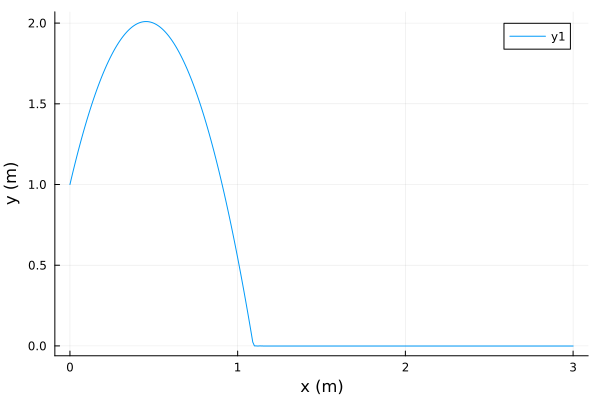

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8702


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("brick" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x68, 0x63, 0x61, 0x74, 0x2f, 0x62, 0x72, 0x69, 0x63, 0x6b], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{Any}(), ip"127.0.0.1", 8702))

In [17]:
include(joinpath(@__DIR__, "animate_brick.jl"))
let 
    
    dt = 0.01 
    T = 3.0 
    
    t_vec = 0:dt:T
    N = length(t_vec)
    
    qs = [zeros(2) for i = 1:N]
    vs = [zeros(2) for i = 1:N]
    
    qs[1] = [0, 1.0]
    vs[1] = [1, 4.5]
    
    # TODO: simulate the brick by forming and solving a qp 
    # at each timestep. Your QP should solve for vs[k+1], and
    # you should use this to update qs[k+1]
    
    for k = 1:(N-1)

        qp = brick_simulation_qp(qs[k],vs[k]; mass = 1.0, Δt = 0.01)

        vs[k+1], λ, μ = solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-6)
        
        qs[k+1] = qs[k] + dt*vs[k+1]
    
    end 
    
    
    
    xs = [q[1] for q in qs]
    ys = [q[2] for q in qs]
    
    @show @test abs(maximum(ys)-2)<1e-1
    @show @test minimum(ys) > -1e-2
    @show @test abs(xs[end] - 3) < 1e-2
    
    xdot = diff(xs)/dt
    @show @test maximum(xdot) < 1.0001
    @show @test minimum(xdot) > 0.9999
    @show @test ys[110] > 1e-2
    @show @test abs(ys[111]) < 1e-2
    @show @test abs(ys[112]) < 1e-2
    
    display(plot(xs, ys, ylabel = "y (m)", xlabel = "x (m)"))
    
    animate_brick(qs)
    
    
    
end